<a href="https://colab.research.google.com/drive/1H5QGOBrpEfGKlDa1anpfvW_nLqdMk-Mq?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center">
  <a href="https://uptrain.ai">
    <img width="300" src="https://user-images.githubusercontent.com/108270398/214240695-4f958b76-c993-4ddd-8de6-8668f4d0da84.png" alt="UpTrain">
  </a>
</h1>

<div style="text-align: center;">

#  Vector embedding retrieval with Chroma and Evaluation with UpTrain


This notebook demonstrates the most basic use of Chroma to store and retrieve information using embeddings. This core building block is at the heart of many powerful AI applications.

## What are embeddings?

Embeddings are the A.I-native way to represent any kind of data, making them the perfect fit for working with all kinds of A.I-powered tools and algorithms. They can represent text, images, and soon audio and video.

To create an embedding, data is fed into an embedding model, which outputs vectors of numbers. The model is trained in such a way that 'similar' data, e.g. text with similar meanings, or images with similar content, will produce vectors which are nearer to one another, than those which are dissimilar.

## Embeddings and retrieval

We can use the similarity property of embeddings to search for and retrieve information. For example, we can find documents relevant to a particular topic, or images similar to a given image. Rather than searching for keywords or tags, we can search by finding data with similar semantic meaning.

## Why do I need to monitor the retrieval quality?

Let's say a user asks your LLM application a question on refunds, maybe something like: "How can I initiate a refund on my last purchase?". Ideally, the retrieved context should contain two important pieces of information: "the user's last purchase" and "the company's policy on refunds". Now, what if the retrieved context doesn't contain that information or the fetched information is irrelevant. That's where UpTrain comes in, by helping you evaluate the relevance of the retrieved context.

## Overview of this notebooks

In this notebook, we will walk you through some basic applications in RAG, using ChromaDB as a vector DB for your context documents. Subsequently, we will use UpTrain to evaluate the quality (relevance) of these retrieved contexts. For simplicity, we have divided this notebook into the following 3 parts:

1. **Data Preparation and Embedding:**
   We will begin by processing and embedding our data using a suitable sentence transformer model. This creates high-dimensional vector representations capturing the semantic meaning of each data point.

2. **Vector Search with ChromaDB:**
   We will then leverage ChromaDB's efficient vector search capabilities to retrieve relevant results based on a query vector, allowing us to explore the semantic relationships within the data.

3. **UpTrain Evaluation of Retrieved Content:**
   Utilizing UpTrain's pre-built and custom evaluation checks, we will analyze the quality of the retrieved search results. This assessment focuses on aspects such as context relevance, factual accuracy, and response completeness wrt context, providing valuable insights into the effectiveness of the search process.



If you face any difficulties, need some help with using UpTrain or want to brainstorm custom evaluations for your use-case, you can speak to the maintainers of UpTrain [here](https://calendly.com/uptrain-sourabh/30min).


In [1]:
# !pip install -Uq chromadb numpy datasets uptrain

## Example Dataset

As a demonstration we use the [SciQ dataset](https://arxiv.org/abs/1707.06209), available from [HuggingFace](https://huggingface.co/datasets/sciq).

Dataset description, from HuggingFace:

> The SciQ dataset contains 13,679 crowdsourced science exam questions about Physics, Chemistry and Biology, among others. The questions are in multiple-choice format with 4 answer options each. For the majority of the questions, an additional paragraph with supporting evidence for the correct answer is provided.

In this notebook, we will demonstrate how to retrieve supporting evidence for a given question.


In [2]:
# Get the SciQ dataset from HuggingFace
from datasets import load_dataset

dataset = load_dataset("sciq", split="train")

# Filter the dataset to only include questions with a support
dataset = dataset.filter(lambda x: x["support"] != "")

print("Number of questions with support: ", len(dataset))

Number of questions with support:  10481


## Loading the data into Chroma

Chroma comes with a built-in embedding model, which makes it simple to load text.
We can load the SciQ dataset into Chroma with just a few lines of code.


In [3]:
# Import Chroma and instantiate a client. The default Chroma client is ephemeral, meaning it will not save to disk.
import chromadb

client = chromadb.Client()

In [4]:
# Get or create a new Chroma collection to store the supporting evidence. We don't need to specify an embedding fuction, and the default will be used.
collection = client.get_or_create_collection("sciq_supports")

In [5]:
# Embed and store the first 100 supports for this demo
collection.add(
    ids=[str(i) for i in range(0, 100)],  # IDs are just strings
    documents=dataset["support"][:100],
    metadatas=[{"type": "support"} for _ in range(0, 100)
    ],
)

## Querying the data

Once the data is loaded, we can use Chroma to find supporting evidence for the questions in the dataset.
In this example, we retrieve the most relevant result according to the embedding similarity score.

Chroma handles computing similarity and finding the most relevant results for you, so you can focus on building your application.


In [6]:
results = collection.query(
    query_texts=dataset["question"][:10],
    n_results=1)

We display the query questions along with their retrieved supports

In [7]:
# Retrieving the corresponding support document wrt question
data = []
for i, q in enumerate(dataset['question'][:10]):
    retrieved_data = {'question': q,
     'context': results['documents'][i][0]}
    data.append(retrieved_data)


##  Evaluating the retrieved context's quality using UpTrain's Open-Source Software (OSS)

In [8]:
# Evaluation using uptrai
import json
from uptrain import EvalLLM, Evals, APIClient, Settings

# Insert your OpenAI key here
OPENAI_API_KEY = "sk-*******************"

eval_llm = EvalLLM(
    Settings(openai_api_key=OPENAI_API_KEY, response_format={"type": "json_object"})
)

res = eval_llm.evaluate(data=data, checks=[Evals.CONTEXT_RELEVANCE])

# Display Evaluation Results
print("Evaluation Results:")
print(json.dumps(res, indent=3))

2024-02-05 12:27:51.099 | INFO     | uptrain.framework.evalllm:evaluate:104 - Sending evaluation request for rows 0 to <50 to the Uptrain


Evaluation Results:
[
   {
      "question": "What type of organism is commonly used in preparation of foods such as cheese and yogurt?",
      "context": "Agents of Decomposition The fungus-like protist saprobes are specialized to absorb nutrients from nonliving organic matter, such as dead organisms or their wastes. For instance, many types of oomycetes grow on dead animals or algae. Saprobic protists have the essential function of returning inorganic nutrients to the soil and water. This process allows for new plant growth, which in turn generates sustenance for other organisms along the food chain. Indeed, without saprobe species, such as protists, fungi, and bacteria, life would cease to exist as all organic carbon became \u201ctied up\u201d in dead organisms.",
      "score_context_relevance": 0.5,
      "explanation_context_relevance": "The extracted context discusses saprobe species, including protists, fungi, and bacteria, which are specialized to absorb nutrients from nonlivi

## [Optional]  UpTrain Managed Service and Dashboards

You can create a free UpTrain account [here](https://uptrain.ai/) and get free trial credits. If you want more trial credits, [book a call with the maintainers of UpTrain here](https://calendly.com/uptrain-sourabh/30min).

UpTrain Managed service provides:

1. Dashboards with advanced drill-down and filtering options
2. Insights and common topics among failing cases
3. Observability and real-time monitoring of production data
4. Regression testing via seamless integration with your CI/CD pipelines

In [9]:
UPTRAIN_API_KEY = "up-******************"  # Insert your UpTrain API key here

uptrain_client = APIClient(
    Settings(
        uptrain_access_token=UPTRAIN_API_KEY, response_format={"type": "json_object"}
    )
)

res = uptrain_client.log_and_evaluate(
    "ChromaDB-context-sample-evals", data, [Evals.CONTEXT_RELEVANCE]
)

# Display Evaluation Results
print("Evaluation Results:")
print(json.dumps(res, indent=3))

2024-02-05 12:27:52.324 | INFO     | uptrain.framework.remote:log_and_evaluate:610 - Sending evaluation request for rows 0 to <50 to the Uptrain server


Evaluation Results:
[
   {
      "question": "What type of organism is commonly used in preparation of foods such as cheese and yogurt?",
      "context": "Agents of Decomposition The fungus-like protist saprobes are specialized to absorb nutrients from nonliving organic matter, such as dead organisms or their wastes. For instance, many types of oomycetes grow on dead animals or algae. Saprobic protists have the essential function of returning inorganic nutrients to the soil and water. This process allows for new plant growth, which in turn generates sustenance for other organisms along the food chain. Indeed, without saprobe species, such as protists, fungi, and bacteria, life would cease to exist as all organic carbon became \u201ctied up\u201d in dead organisms.",
      "score_context_relevance": 0.5,
      "explanation_context_relevance": "The extracted context discusses saprobe species, including protists, fungi, and bacteria, which are specialized to absorb nutrients from nonlivi

### Dashboards:

Histogram of score vs number of cases with that score
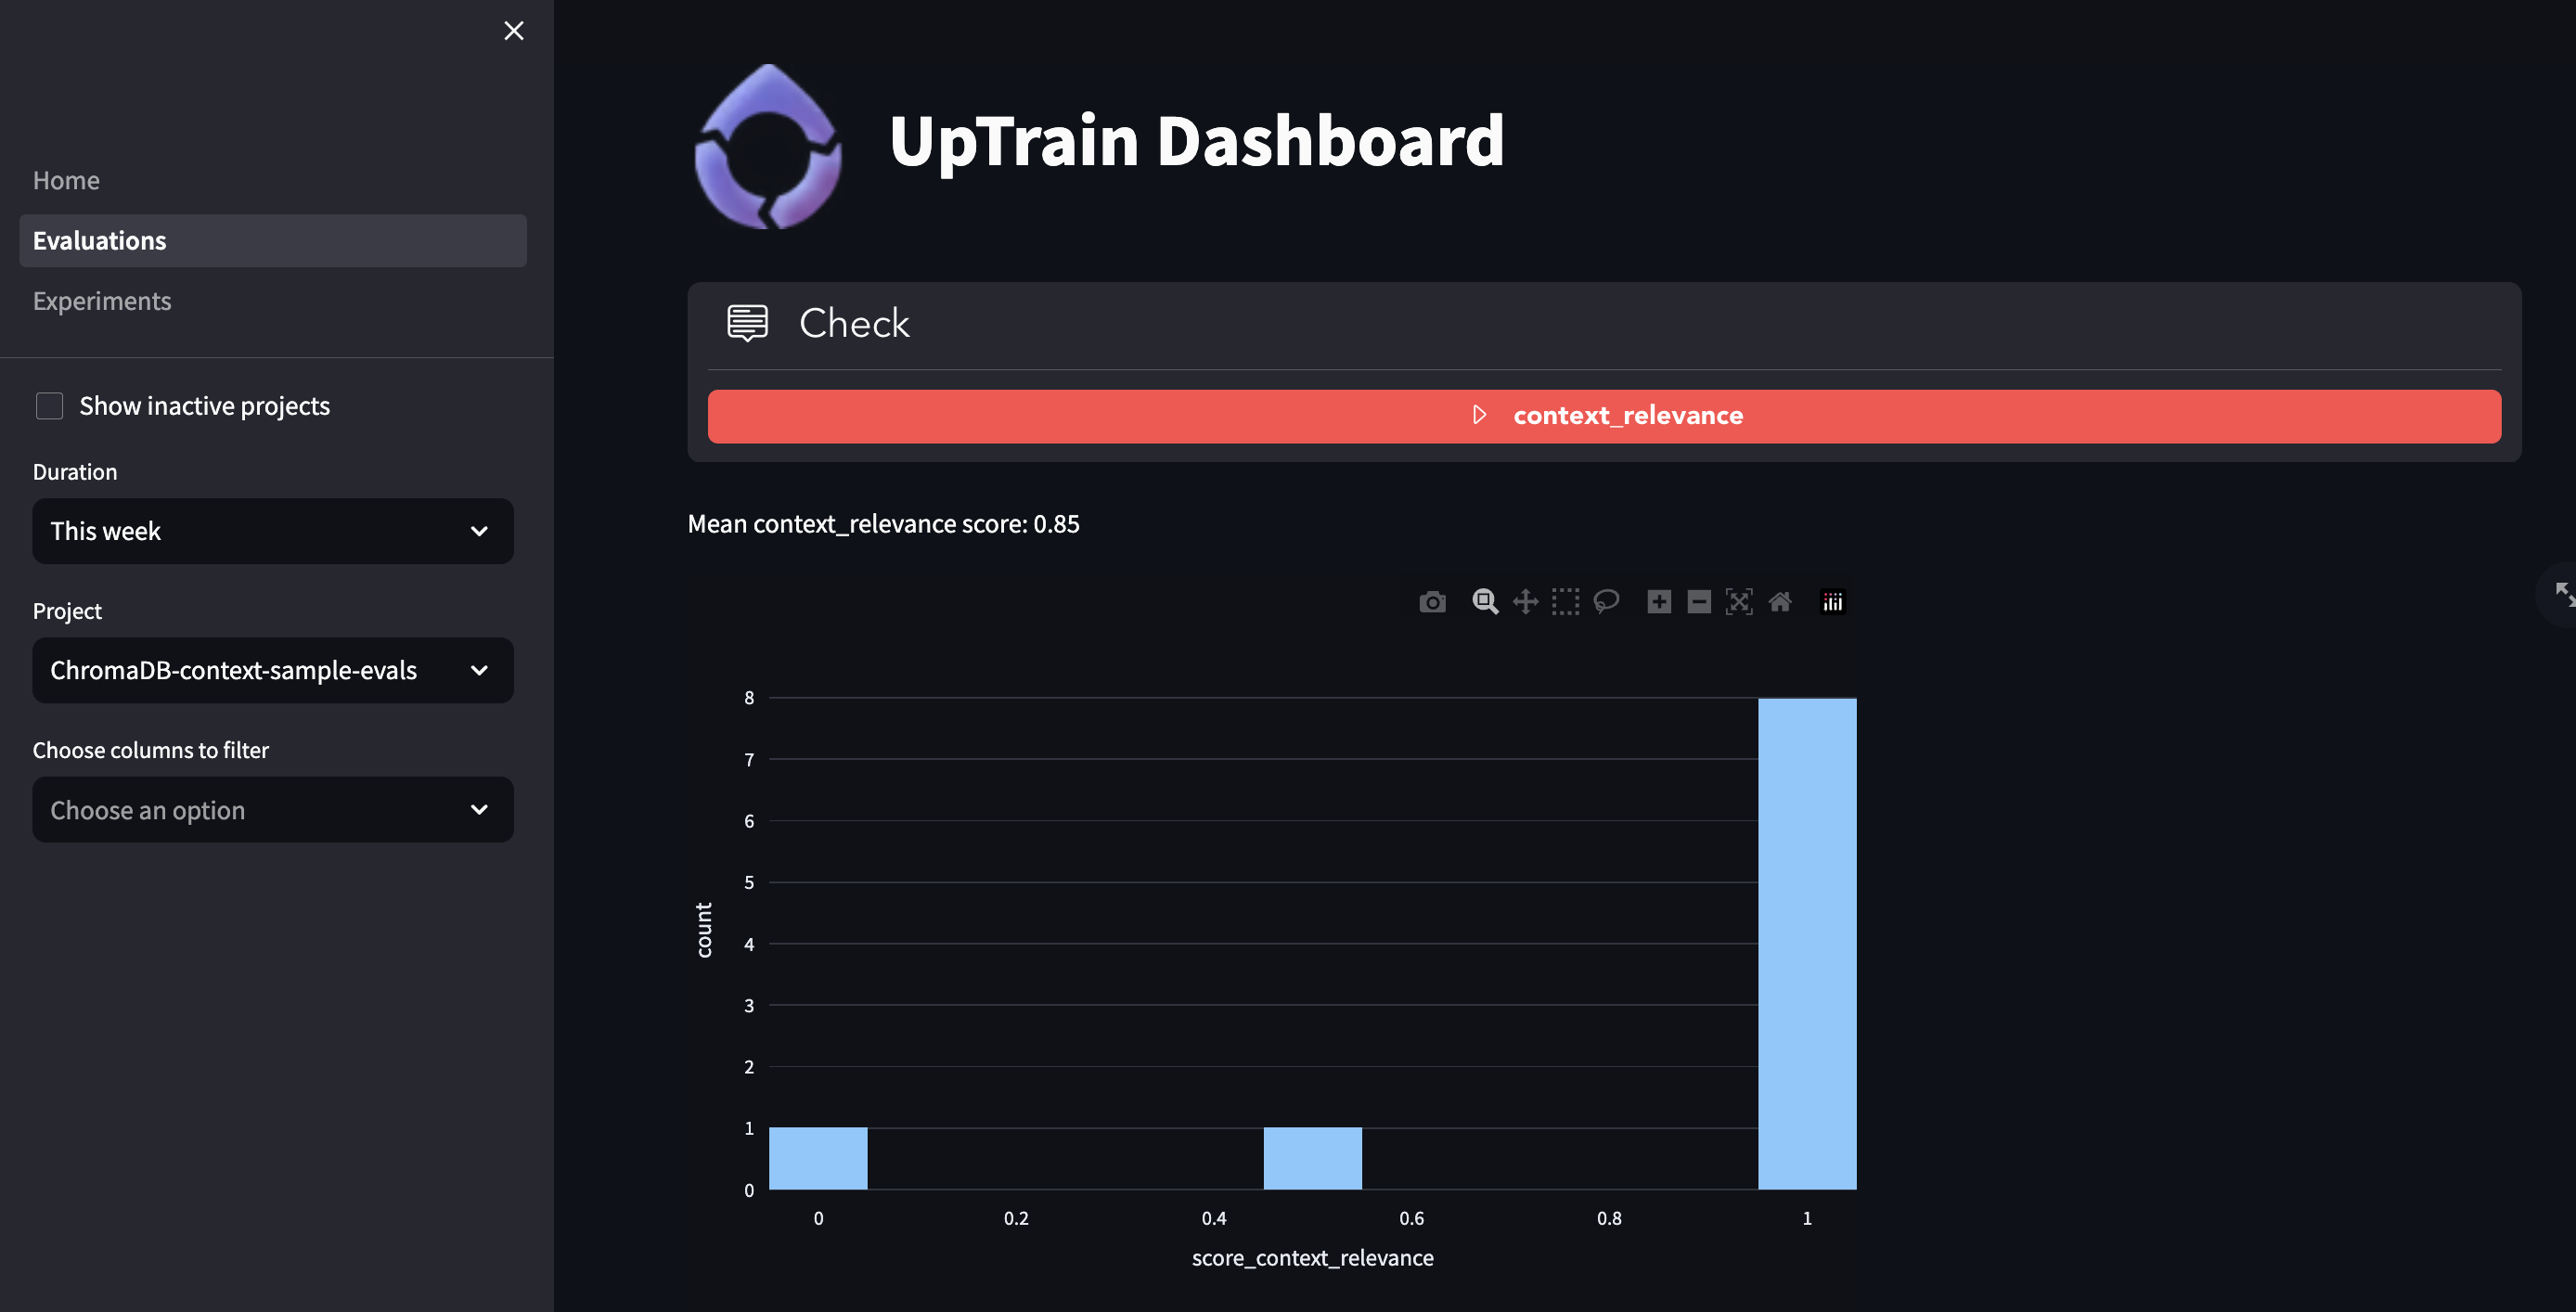

You can access the uptrain dashboards [here](https://demo.uptrain.ai/dashboard/) by using the above defined UPTRAIN_API_KEY


### Insights:

You can filter failure cases and generate common topics among them. This can help identify the core issue and help fix it

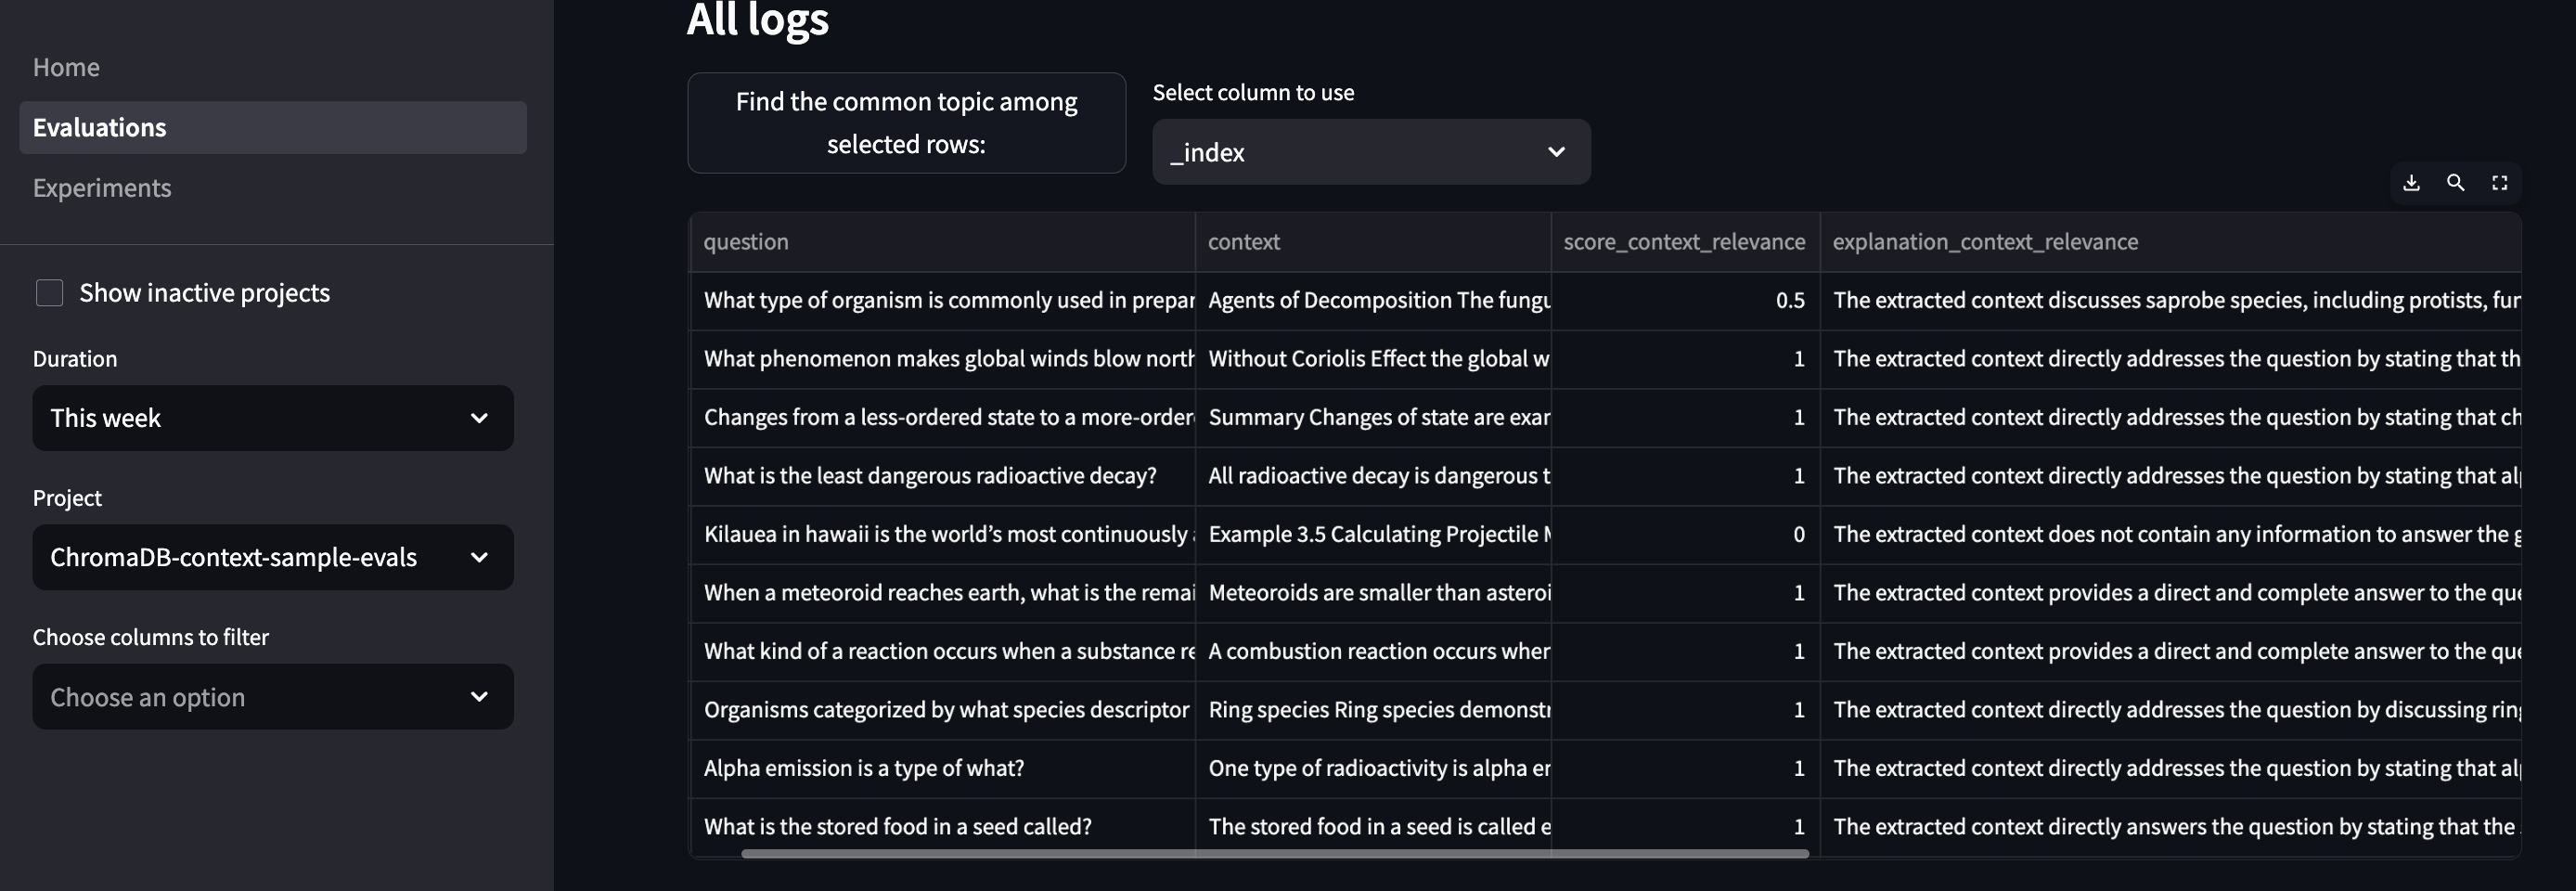